In [1]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [2]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [3]:
!pip install huggingface-hub==0.16.4


  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.6
    Uninstalling huggingface-hub-0.24.6:
      Successfully uninstalled huggingface-hub-0.24.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [4]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


c:\Users\Yang_PC\anaconda3\envs\py310cuda118\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


device(type='cuda')

In [6]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [8]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
# Example usage
main_folder = r'D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay'

train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')
    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Image Path: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\valid\image\BL_BB_19_row1_col6.png
Mask Path: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\valid\index\BL_BB_19_row1_col6.png


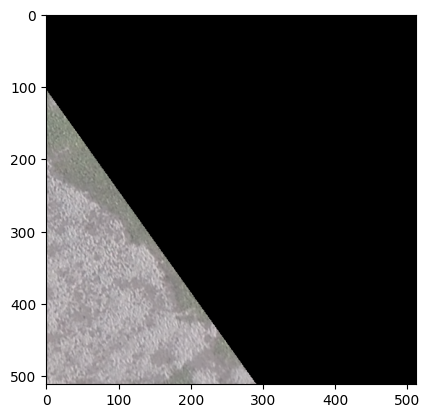

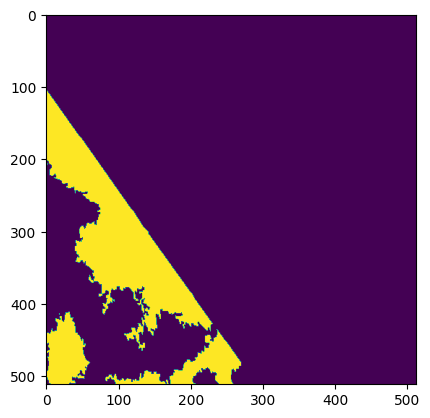

(512, 512, 3)
(512, 512)


In [9]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [13]:
from pathlib import Path

class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass

In [14]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(train_image_folder, train_mask_folder, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(val_image_folder, val_mask_folder, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [15]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [16]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [17]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [19]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [20]:
torch.cuda.empty_cache()

In [21]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Fri Oct 18 22:53:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   38C    P8              8W /  170W |     542MiB /  12288MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model, 'Unet-mobilenet2-batchsize8-BB_lr-4.pt')

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.642 
Epoch:1/20.. Train Loss: 0.738.. Val Loss: 0.642.. Train mIoU:0.376.. Val mIoU: 0.453.. Train Acc:0.549.. Val Acc:0.630.. Time: 30.99m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.642 >> 0.567 
Epoch:2/20.. Train Loss: 0.613.. Val Loss: 0.567.. Train mIoU:0.481.. Val mIoU: 0.546.. Train Acc:0.651.. Val Acc:0.716.. Time: 28.43m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.567 >> 0.519 
Epoch:3/20.. Train Loss: 0.543.. Val Loss: 0.519.. Train mIoU:0.555.. Val mIoU: 0.581.. Train Acc:0.716.. Val Acc:0.750.. Time: 28.29m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.519 >> 0.455 
saving model...
Epoch:4/20.. Train Loss: 0.514.. Val Loss: 0.455.. Train mIoU:0.583.. Val mIoU: 0.626.. Train Acc:0.739.. Val Acc:0.780.. Time: 29.45m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.455 >> 0.431 
Epoch:5/20.. Train Loss: 0.480.. Val Loss: 0.431.. Train mIoU:0.622.. Val mIoU: 0.646.. Train Acc:0.768.. Val Acc:0.791.. Time: 28.90m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/20.. Train Loss: 0.470.. Val Loss: 0.445.. Train mIoU:0.625.. Val mIoU: 0.623.. Train Acc:0.770.. Val Acc:0.783.. Time: 28.31m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.445 >> 0.423 
Epoch:7/20.. Train Loss: 0.468.. Val Loss: 0.423.. Train mIoU:0.628.. Val mIoU: 0.641.. Train Acc:0.773.. Val Acc:0.793.. Time: 28.90m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/20.. Train Loss: 0.458.. Val Loss: 0.438.. Train mIoU:0.637.. Val mIoU: 0.648.. Train Acc:0.781.. Val Acc:0.793.. Time: 28.42m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.438 >> 0.412 
Epoch:9/20.. Train Loss: 0.442.. Val Loss: 0.412.. Train mIoU:0.654.. Val mIoU: 0.676.. Train Acc:0.793.. Val Acc:0.814.. Time: 29.49m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.383 
Epoch:10/20.. Train Loss: 0.431.. Val Loss: 0.383.. Train mIoU:0.657.. Val mIoU: 0.698.. Train Acc:0.795.. Val Acc:0.827.. Time: 30.25m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/20.. Train Loss: 0.423.. Val Loss: 0.399.. Train mIoU:0.667.. Val mIoU: 0.707.. Train Acc:0.802.. Val Acc:0.833.. Time: 29.79m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.399 >> 0.386 
saving model...
Epoch:12/20.. Train Loss: 0.417.. Val Loss: 0.386.. Train mIoU:0.676.. Val mIoU: 0.686.. Train Acc:0.808.. Val Acc:0.822.. Time: 28.97m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.386 >> 0.359 
Epoch:13/20.. Train Loss: 0.415.. Val Loss: 0.359.. Train mIoU:0.666.. Val mIoU: 0.722.. Train Acc:0.803.. Val Acc:0.844.. Time: 28.42m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/20.. Train Loss: 0.400.. Val Loss: 0.387.. Train mIoU:0.683.. Val mIoU: 0.700.. Train Acc:0.814.. Val Acc:0.831.. Time: 28.78m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:15/20.. Train Loss: 0.405.. Val Loss: 0.388.. Train mIoU:0.678.. Val mIoU: 0.708.. Train Acc:0.810.. Val Acc:0.834.. Time: 28.50m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.388 >> 0.373 
Epoch:16/20.. Train Loss: 0.391.. Val Loss: 0.373.. Train mIoU:0.689.. Val mIoU: 0.711.. Train Acc:0.819.. Val Acc:0.835.. Time: 28.25m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.373 >> 0.364 
Epoch:17/20.. Train Loss: 0.393.. Val Loss: 0.364.. Train mIoU:0.693.. Val mIoU: 0.719.. Train Acc:0.822.. Val Acc:0.842.. Time: 28.41m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.364 >> 0.358 
Epoch:18/20.. Train Loss: 0.380.. Val Loss: 0.358.. Train mIoU:0.700.. Val mIoU: 0.728.. Train Acc:0.826.. Val Acc:0.846.. Time: 28.39m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:19/20.. Train Loss: 0.385.. Val Loss: 0.366.. Train mIoU:0.693.. Val mIoU: 0.718.. Train Acc:0.823.. Val Acc:0.841.. Time: 28.58m


  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Loss Decreasing.. 0.366 >> 0.362 
saving model...
Epoch:20/20.. Train Loss: 0.384.. Val Loss: 0.362.. Train mIoU:0.697.. Val mIoU: 0.716.. Train Acc:0.824.. Val Acc:0.842.. Time: 28.35m
Total time: 577.89 m


In [26]:
model_path = r'C:\Users\Yang_PC\Documents\Github\ArcgisPro-Customized-Toolbox\Notebook\Unet-mobilenet2-batchsize8-BB_lr-4.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [27]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

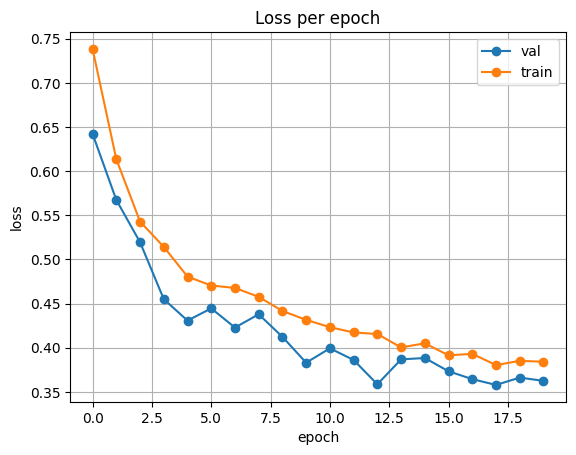

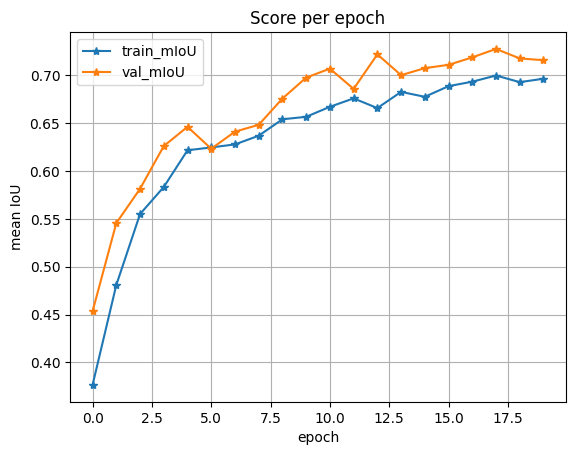

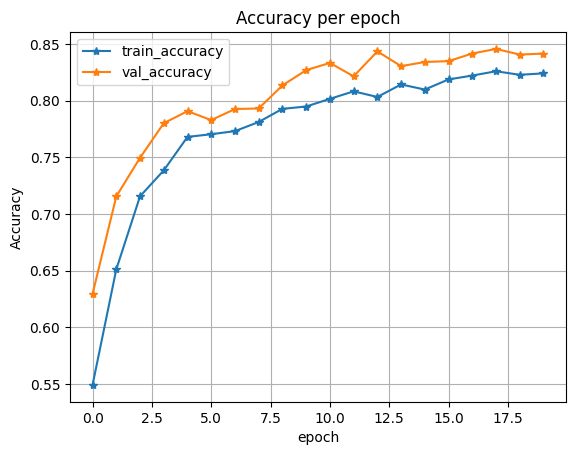

In [28]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [29]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [30]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score



def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.5):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [78,156,217]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [32]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")


  1%|          | 1/157 [00:00<02:28,  1.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_19_row4_col6.png
Saved predicted mask for BL_BB_19_row4_col6.png with mIoU score: 0.356


  1%|▏         | 2/157 [00:01<01:29,  1.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_19_row6_col8.png
Saved predicted mask for BL_BB_19_row6_col8.png with mIoU score: 0.537


  2%|▏         | 3/157 [00:01<01:05,  2.34it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row11_col15.png
Saved predicted mask for BL_BB_20_row11_col15.png with mIoU score: 0.121


  3%|▎         | 4/157 [00:01<00:58,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row12_col11.png
Saved predicted mask for BL_BB_20_row12_col11.png with mIoU score: 0.069


  4%|▍         | 6/157 [00:02<00:43,  3.43it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row12_col5.png
Saved predicted mask for BL_BB_20_row12_col5.png with mIoU score: 0.996
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row13_col18.png
Saved predicted mask for BL_BB_20_row13_col18.png with mIoU score: 0.980


  4%|▍         | 7/157 [00:02<00:48,  3.09it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row3_col7.png
Saved predicted mask for BL_BB_20_row3_col7.png with mIoU score: 0.549


  5%|▌         | 8/157 [00:02<00:45,  3.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row4_col4.png
Saved predicted mask for BL_BB_20_row4_col4.png with mIoU score: 0.978


  6%|▌         | 9/157 [00:03<00:46,  3.16it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row4_col7.png
Saved predicted mask for BL_BB_20_row4_col7.png with mIoU score: 0.474


  6%|▋         | 10/157 [00:03<00:48,  3.05it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row6_col8.png
Saved predicted mask for BL_BB_20_row6_col8.png with mIoU score: 0.482


  7%|▋         | 11/157 [00:04<00:50,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row8_col8.png
Saved predicted mask for BL_BB_20_row8_col8.png with mIoU score: 0.174


  8%|▊         | 12/157 [00:04<00:50,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_20_row9_col13.png
Saved predicted mask for BL_BB_20_row9_col13.png with mIoU score: 0.533


  8%|▊         | 13/157 [00:04<00:50,  2.86it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row10_col12.png
Saved predicted mask for BL_BB_21_row10_col12.png with mIoU score: 0.785


  9%|▉         | 14/157 [00:05<00:50,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row11_col10.png
Saved predicted mask for BL_BB_21_row11_col10.png with mIoU score: 0.319


 10%|▉         | 15/157 [00:05<00:50,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row12_col9.png
Saved predicted mask for BL_BB_21_row12_col9.png with mIoU score: 0.077


 10%|█         | 16/157 [00:05<00:49,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row13_col15.png
Saved predicted mask for BL_BB_21_row13_col15.png with mIoU score: 0.934


 11%|█         | 17/157 [00:06<00:47,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row3_col6.png
Saved predicted mask for BL_BB_21_row3_col6.png with mIoU score: 0.759


 11%|█▏        | 18/157 [00:06<00:46,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row5_col12.png
Saved predicted mask for BL_BB_21_row5_col12.png with mIoU score: 0.750


 12%|█▏        | 19/157 [00:06<00:46,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row5_col7.png
Saved predicted mask for BL_BB_21_row5_col7.png with mIoU score: 0.447


 13%|█▎        | 20/157 [00:07<00:46,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row5_col9.png
Saved predicted mask for BL_BB_21_row5_col9.png with mIoU score: 0.919


 13%|█▎        | 21/157 [00:07<00:41,  3.31it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row7_col1.png
Saved predicted mask for BL_BB_21_row7_col1.png with mIoU score: 0.998


 14%|█▍        | 22/157 [00:07<00:42,  3.19it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row8_col11.png
Saved predicted mask for BL_BB_21_row8_col11.png with mIoU score: 0.797


 15%|█▍        | 23/157 [00:07<00:41,  3.21it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_21_row8_col14.png
Saved predicted mask for BL_BB_21_row8_col14.png with mIoU score: 0.923


 15%|█▌        | 24/157 [00:08<00:41,  3.17it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_22_row11_col10.png
Saved predicted mask for BL_BB_22_row11_col10.png with mIoU score: 0.619


 16%|█▌        | 25/157 [00:08<00:38,  3.44it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_22_row12_col7.png
Saved predicted mask for BL_BB_22_row12_col7.png with mIoU score: 0.927


 17%|█▋        | 26/157 [00:08<00:37,  3.50it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_22_row2_col8.png
Saved predicted mask for BL_BB_22_row2_col8.png with mIoU score: 0.939


 17%|█▋        | 27/157 [00:09<00:38,  3.37it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\BL_BB_22_row6_col2.png
Saved predicted mask for BL_BB_22_row6_col2.png with mIoU score: 0.326


 18%|█▊        | 29/157 [00:09<00:35,  3.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row10_col9.png
Saved predicted mask for CC_BB_20_row10_col9.png with mIoU score: 0.008
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row11_col16.png
Saved predicted mask for CC_BB_20_row11_col16.png with mIoU score: 0.999


 19%|█▉        | 30/157 [00:09<00:35,  3.59it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row13_col12.png
Saved predicted mask for CC_BB_20_row13_col12.png with mIoU score: 0.709


 20%|█▉        | 31/157 [00:10<00:38,  3.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row7_col6.png
Saved predicted mask for CC_BB_20_row7_col6.png with mIoU score: 0.933


 20%|██        | 32/157 [00:10<00:38,  3.23it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row8_col14.png
Saved predicted mask for CC_BB_20_row8_col14.png with mIoU score: 0.000


 21%|██        | 33/157 [00:11<00:44,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row9_col10.png
Saved predicted mask for CC_BB_20_row9_col10.png with mIoU score: 0.183


 22%|██▏       | 34/157 [00:11<00:44,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row9_col11.png
Saved predicted mask for CC_BB_20_row9_col11.png with mIoU score: 0.000


 22%|██▏       | 35/157 [00:11<00:45,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_20_row9_col9.png
Saved predicted mask for CC_BB_20_row9_col9.png with mIoU score: 0.414


 23%|██▎       | 36/157 [00:12<00:44,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row10_col1.png
Saved predicted mask for CC_BB_21_row10_col1.png with mIoU score: 0.715


 24%|██▎       | 37/157 [00:12<00:43,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row11_col5.png
Saved predicted mask for CC_BB_21_row11_col5.png with mIoU score: 0.636


 24%|██▍       | 38/157 [00:12<00:43,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row2_col8.png
Saved predicted mask for CC_BB_21_row2_col8.png with mIoU score: 0.203


 25%|██▍       | 39/157 [00:13<00:42,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row4_col8.png
Saved predicted mask for CC_BB_21_row4_col8.png with mIoU score: 0.343


 25%|██▌       | 40/157 [00:13<00:43,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row7_col12.png
Saved predicted mask for CC_BB_21_row7_col12.png with mIoU score: 0.820


 26%|██▌       | 41/157 [00:13<00:39,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row7_col3.png
Saved predicted mask for CC_BB_21_row7_col3.png with mIoU score: 0.867


 27%|██▋       | 42/157 [00:14<00:41,  2.79it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row7_col7.png
Saved predicted mask for CC_BB_21_row7_col7.png with mIoU score: 0.697


 27%|██▋       | 43/157 [00:14<00:40,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row8_col12.png
Saved predicted mask for CC_BB_21_row8_col12.png with mIoU score: 0.686


 28%|██▊       | 44/157 [00:15<00:38,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row8_col7.png
Saved predicted mask for CC_BB_21_row8_col7.png with mIoU score: 0.518


 29%|██▊       | 45/157 [00:15<00:39,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row8_col9.png
Saved predicted mask for CC_BB_21_row8_col9.png with mIoU score: 0.728


 29%|██▉       | 46/157 [00:15<00:37,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_21_row9_col10.png
Saved predicted mask for CC_BB_21_row9_col10.png with mIoU score: 0.065


 30%|██▉       | 47/157 [00:16<00:37,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_22_row3_col3.png
Saved predicted mask for CC_BB_22_row3_col3.png with mIoU score: 0.624


 31%|███       | 48/157 [00:16<00:35,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_22_row4_col5.png
Saved predicted mask for CC_BB_22_row4_col5.png with mIoU score: 0.712


 31%|███       | 49/157 [00:16<00:34,  3.11it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_22_row5_col1.png
Saved predicted mask for CC_BB_22_row5_col1.png with mIoU score: 0.756


 32%|███▏      | 50/157 [00:17<00:35,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\CC_BB_22_row6_col2.png
Saved predicted mask for CC_BB_22_row6_col2.png with mIoU score: 0.519


 32%|███▏      | 51/157 [00:17<00:35,  3.01it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row11_col6.png
Saved predicted mask for MM_BB_19_row11_col6.png with mIoU score: 0.656


 33%|███▎      | 52/157 [00:17<00:33,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row12_col13.png
Saved predicted mask for MM_BB_19_row12_col13.png with mIoU score: 0.851


 34%|███▍      | 53/157 [00:17<00:33,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row13_col9.png
Saved predicted mask for MM_BB_19_row13_col9.png with mIoU score: 0.700


 34%|███▍      | 54/157 [00:18<00:33,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row1_col9.png
Saved predicted mask for MM_BB_19_row1_col9.png with mIoU score: 0.841


 35%|███▌      | 55/157 [00:18<00:34,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row2_col5.png
Saved predicted mask for MM_BB_19_row2_col5.png with mIoU score: 0.678


 36%|███▌      | 56/157 [00:19<00:34,  2.96it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row2_col6.png
Saved predicted mask for MM_BB_19_row2_col6.png with mIoU score: 0.623


 36%|███▋      | 57/157 [00:19<00:34,  2.94it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row3_col5.png
Saved predicted mask for MM_BB_19_row3_col5.png with mIoU score: 0.691


 37%|███▋      | 58/157 [00:19<00:33,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row3_col7.png
Saved predicted mask for MM_BB_19_row3_col7.png with mIoU score: 0.010


 38%|███▊      | 59/157 [00:20<00:36,  2.65it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row4_col4.png
Saved predicted mask for MM_BB_19_row4_col4.png with mIoU score: 0.913


 38%|███▊      | 60/157 [00:20<00:36,  2.67it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row5_col9.png
Saved predicted mask for MM_BB_19_row5_col9.png with mIoU score: 0.525


 39%|███▉      | 61/157 [00:20<00:35,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_19_row6_col7.png
Saved predicted mask for MM_BB_19_row6_col7.png with mIoU score: 0.227


 39%|███▉      | 62/157 [00:21<00:35,  2.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_20_row10_col11.png
Saved predicted mask for MM_BB_20_row10_col11.png with mIoU score: 0.048


 40%|████      | 63/157 [00:21<00:34,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_20_row12_col10.png
Saved predicted mask for MM_BB_20_row12_col10.png with mIoU score: 0.798


 41%|████      | 64/157 [00:21<00:33,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_20_row6_col5.png
Saved predicted mask for MM_BB_20_row6_col5.png with mIoU score: 0.369


 41%|████▏     | 65/157 [00:22<00:33,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_20_row7_col10.png
Saved predicted mask for MM_BB_20_row7_col10.png with mIoU score: 0.167


 42%|████▏     | 66/157 [00:22<00:33,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_21_row10_col6.png
Saved predicted mask for MM_BB_21_row10_col6.png with mIoU score: 0.391


 43%|████▎     | 67/157 [00:22<00:28,  3.14it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_21_row15_col10.png
Saved predicted mask for MM_BB_21_row15_col10.png with mIoU score: 0.993


 43%|████▎     | 68/157 [00:23<00:28,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_21_row1_col9.png
Saved predicted mask for MM_BB_21_row1_col9.png with mIoU score: 0.918


 44%|████▍     | 69/157 [00:23<00:29,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_21_row3_col7.png
Saved predicted mask for MM_BB_21_row3_col7.png with mIoU score: 0.806


 45%|████▍     | 70/157 [00:23<00:29,  2.98it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_21_row9_col10.png
Saved predicted mask for MM_BB_21_row9_col10.png with mIoU score: 0.158


 45%|████▌     | 71/157 [00:24<00:28,  3.01it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row1_col4.png
Saved predicted mask for MM_BB_22_row1_col4.png with mIoU score: 0.901


 46%|████▌     | 72/157 [00:24<00:29,  2.85it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row2_col2.png
Saved predicted mask for MM_BB_22_row2_col2.png with mIoU score: 0.643


 46%|████▋     | 73/157 [00:25<00:30,  2.72it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row2_col3.png
Saved predicted mask for MM_BB_22_row2_col3.png with mIoU score: 0.167


 47%|████▋     | 74/157 [00:25<00:36,  2.27it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row3_col3.png
Saved predicted mask for MM_BB_22_row3_col3.png with mIoU score: 0.056


 48%|████▊     | 75/157 [00:26<00:35,  2.31it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row5_col7.png
Saved predicted mask for MM_BB_22_row5_col7.png with mIoU score: 0.180


 48%|████▊     | 76/157 [00:26<00:34,  2.35it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row8_col4.png
Saved predicted mask for MM_BB_22_row8_col4.png with mIoU score: 0.286


 49%|████▉     | 77/157 [00:26<00:34,  2.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row8_col6.png
Saved predicted mask for MM_BB_22_row8_col6.png with mIoU score: 0.036


 50%|████▉     | 78/157 [00:27<00:33,  2.39it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row8_col7.png
Saved predicted mask for MM_BB_22_row8_col7.png with mIoU score: 0.489


 50%|█████     | 79/157 [00:27<00:32,  2.40it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MM_BB_22_row9_col3.png
Saved predicted mask for MM_BB_22_row9_col3.png with mIoU score: 0.730


 51%|█████     | 80/157 [00:28<00:29,  2.60it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_19_row10_col8.png
Saved predicted mask for MT_BB_19_row10_col8.png with mIoU score: 0.901


 52%|█████▏    | 81/157 [00:28<00:28,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_19_row4_col5.png
Saved predicted mask for MT_BB_19_row4_col5.png with mIoU score: 0.031


 52%|█████▏    | 82/157 [00:28<00:32,  2.34it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_19_row5_col12.png
Saved predicted mask for MT_BB_19_row5_col12.png with mIoU score: 0.008


 53%|█████▎    | 83/157 [00:29<00:30,  2.41it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_19_row5_col3.png
Saved predicted mask for MT_BB_19_row5_col3.png with mIoU score: 0.000


 54%|█████▎    | 84/157 [00:29<00:27,  2.64it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_19_row9_col12.png
Saved predicted mask for MT_BB_19_row9_col12.png with mIoU score: 0.577


 54%|█████▍    | 85/157 [00:29<00:26,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row10_col14.png
Saved predicted mask for MT_BB_20_row10_col14.png with mIoU score: 0.164


 55%|█████▍    | 86/157 [00:30<00:23,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row10_col15.png
Saved predicted mask for MT_BB_20_row10_col15.png with mIoU score: 0.760


 55%|█████▌    | 87/157 [00:30<00:24,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row12_col11.png
Saved predicted mask for MT_BB_20_row12_col11.png with mIoU score: 0.986


 56%|█████▌    | 88/157 [00:31<00:25,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row5_col9.png
Saved predicted mask for MT_BB_20_row5_col9.png with mIoU score: 0.674


 57%|█████▋    | 89/157 [00:31<00:22,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row6_col2.png
Saved predicted mask for MT_BB_20_row6_col2.png with mIoU score: 0.956


 57%|█████▋    | 90/157 [00:31<00:23,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row7_col14.png
Saved predicted mask for MT_BB_20_row7_col14.png with mIoU score: 0.565


 58%|█████▊    | 91/157 [00:31<00:22,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row7_col15.png
Saved predicted mask for MT_BB_20_row7_col15.png with mIoU score: 0.728


 59%|█████▊    | 92/157 [00:32<00:22,  2.90it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row7_col7.png
Saved predicted mask for MT_BB_20_row7_col7.png with mIoU score: 0.566


 59%|█████▉    | 93/157 [00:32<00:22,  2.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_20_row8_col7.png
Saved predicted mask for MT_BB_20_row8_col7.png with mIoU score: 0.889


 60%|█████▉    | 94/157 [00:33<00:21,  2.88it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_21_row5_col3.png
Saved predicted mask for MT_BB_21_row5_col3.png with mIoU score: 0.339


 61%|██████    | 95/157 [00:33<00:21,  2.93it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_21_row6_col16.png
Saved predicted mask for MT_BB_21_row6_col16.png with mIoU score: 0.586


 61%|██████    | 96/157 [00:33<00:21,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_21_row7_col12.png
Saved predicted mask for MT_BB_21_row7_col12.png with mIoU score: 0.217


 62%|██████▏   | 98/157 [00:34<00:18,  3.24it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_21_row8_col11.png
Saved predicted mask for MT_BB_21_row8_col11.png with mIoU score: 0.276
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_22_row7_col10.png
Saved predicted mask for MT_BB_22_row7_col10.png with mIoU score: 0.998


 63%|██████▎   | 99/157 [00:34<00:18,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\MT_BB_22_row8_col8.png
Saved predicted mask for MT_BB_22_row8_col8.png with mIoU score: 0.948


 64%|██████▍   | 101/157 [00:35<00:15,  3.69it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row1_col4.png
Saved predicted mask for NC_BB_19_row1_col4.png with mIoU score: 0.806
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row1_col9.png
Saved predicted mask for NC_BB_19_row1_col9.png with mIoU score: 0.999


 65%|██████▍   | 102/157 [00:35<00:16,  3.38it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row3_col3.png
Saved predicted mask for NC_BB_19_row3_col3.png with mIoU score: 0.313


 66%|██████▌   | 103/157 [00:35<00:17,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row5_col4.png
Saved predicted mask for NC_BB_19_row5_col4.png with mIoU score: 0.191


 66%|██████▌   | 104/157 [00:36<00:16,  3.17it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row6_col13.png
Saved predicted mask for NC_BB_19_row6_col13.png with mIoU score: 0.996


 67%|██████▋   | 105/157 [00:36<00:16,  3.13it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row7_col3.png
Saved predicted mask for NC_BB_19_row7_col3.png with mIoU score: 0.657


 68%|██████▊   | 107/157 [00:37<00:18,  2.76it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_19_row8_col7.png
Saved predicted mask for NC_BB_19_row8_col7.png with mIoU score: 0.998
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row11_col11.png
Saved predicted mask for NC_BB_20_row11_col11.png with mIoU score: 0.999


 69%|██████▉   | 108/157 [00:37<00:16,  3.04it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row2_col15.png
Saved predicted mask for NC_BB_20_row2_col15.png with mIoU score: 0.998


 69%|██████▉   | 109/157 [00:37<00:15,  3.12it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row7_col17.png
Saved predicted mask for NC_BB_20_row7_col17.png with mIoU score: 0.640


 70%|███████   | 110/157 [00:38<00:15,  3.06it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row7_col7.png
Saved predicted mask for NC_BB_20_row7_col7.png with mIoU score: 0.574


 71%|███████   | 111/157 [00:38<00:14,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row9_col2.png
Saved predicted mask for NC_BB_20_row9_col2.png with mIoU score: 0.860


 71%|███████▏  | 112/157 [00:38<00:14,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_20_row9_col7.png
Saved predicted mask for NC_BB_20_row9_col7.png with mIoU score: 0.000


 72%|███████▏  | 113/157 [00:39<00:13,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row10_col8.png
Saved predicted mask for NC_BB_21_row10_col8.png with mIoU score: 0.827


 73%|███████▎  | 114/157 [00:39<00:13,  3.19it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row10_col9.png
Saved predicted mask for NC_BB_21_row10_col9.png with mIoU score: 0.726


 73%|███████▎  | 115/157 [00:39<00:12,  3.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row1_col2.png
Saved predicted mask for NC_BB_21_row1_col2.png with mIoU score: 0.877


 75%|███████▍  | 117/157 [00:40<00:10,  3.87it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row1_col6.png
Saved predicted mask for NC_BB_21_row1_col6.png with mIoU score: 0.892
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row2_col17.png
Saved predicted mask for NC_BB_21_row2_col17.png with mIoU score: 0.991


 75%|███████▌  | 118/157 [00:40<00:10,  3.55it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row4_col14.png
Saved predicted mask for NC_BB_21_row4_col14.png with mIoU score: 0.000


 76%|███████▌  | 119/157 [00:40<00:11,  3.28it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row5_col8.png
Saved predicted mask for NC_BB_21_row5_col8.png with mIoU score: 0.000


 76%|███████▋  | 120/157 [00:41<00:11,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row6_col11.png
Saved predicted mask for NC_BB_21_row6_col11.png with mIoU score: 0.000


 77%|███████▋  | 121/157 [00:41<00:11,  3.02it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row7_col13.png
Saved predicted mask for NC_BB_21_row7_col13.png with mIoU score: 0.000


 78%|███████▊  | 122/157 [00:41<00:11,  2.95it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row7_col14.png
Saved predicted mask for NC_BB_21_row7_col14.png with mIoU score: 0.000


 78%|███████▊  | 123/157 [00:42<00:12,  2.75it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row8_col10.png
Saved predicted mask for NC_BB_21_row8_col10.png with mIoU score: 0.000


 79%|███████▉  | 124/157 [00:42<00:11,  2.82it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row8_col11.png
Saved predicted mask for NC_BB_21_row8_col11.png with mIoU score: 0.000


 80%|███████▉  | 125/157 [00:43<00:11,  2.89it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row8_col7.png
Saved predicted mask for NC_BB_21_row8_col7.png with mIoU score: 0.000


 80%|████████  | 126/157 [00:43<00:10,  2.91it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_21_row9_col7.png
Saved predicted mask for NC_BB_21_row9_col7.png with mIoU score: 0.000


 81%|████████  | 127/157 [00:43<00:09,  3.18it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_22_row1_col2.png
Saved predicted mask for NC_BB_22_row1_col2.png with mIoU score: 0.899


 82%|████████▏ | 128/157 [00:44<00:09,  2.97it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_22_row2_col6.png
Saved predicted mask for NC_BB_22_row2_col6.png with mIoU score: 0.557


 82%|████████▏ | 129/157 [00:44<00:09,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_22_row4_col1.png
Saved predicted mask for NC_BB_22_row4_col1.png with mIoU score: 0.948


 83%|████████▎ | 130/157 [00:44<00:09,  2.99it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_22_row6_col8.png
Saved predicted mask for NC_BB_22_row6_col8.png with mIoU score: 0.000


 83%|████████▎ | 131/157 [00:45<00:09,  2.78it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\NC_BB_22_row9_col10.png
Saved predicted mask for NC_BB_22_row9_col10.png with mIoU score: 0.911


 84%|████████▍ | 132/157 [00:45<00:08,  2.84it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row10_col4.png
Saved predicted mask for WE_BB_19_row10_col4.png with mIoU score: 0.805


 85%|████████▍ | 133/157 [00:45<00:07,  3.08it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row11_col11.png
Saved predicted mask for WE_BB_19_row11_col11.png with mIoU score: 0.795


 85%|████████▌ | 134/157 [00:46<00:07,  3.10it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row11_col7.png
Saved predicted mask for WE_BB_19_row11_col7.png with mIoU score: 0.000


 86%|████████▌ | 135/157 [00:46<00:07,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row12_col5.png
Saved predicted mask for WE_BB_19_row12_col5.png with mIoU score: 0.000


 87%|████████▋ | 136/157 [00:46<00:06,  3.07it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row1_col6.png
Saved predicted mask for WE_BB_19_row1_col6.png with mIoU score: 0.712


 87%|████████▋ | 137/157 [00:46<00:06,  3.32it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row2_col3.png
Saved predicted mask for WE_BB_19_row2_col3.png with mIoU score: 0.912


 88%|████████▊ | 138/157 [00:47<00:06,  3.03it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row4_col4.png
Saved predicted mask for WE_BB_19_row4_col4.png with mIoU score: 0.730


 89%|████████▊ | 139/157 [00:47<00:05,  3.04it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row4_col5.png
Saved predicted mask for WE_BB_19_row4_col5.png with mIoU score: 0.944


 90%|████████▉ | 141/157 [00:48<00:04,  3.46it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_19_row5_col5.png
Saved predicted mask for WE_BB_19_row5_col5.png with mIoU score: 0.900
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_20_row11_col11.png
Saved predicted mask for WE_BB_20_row11_col11.png with mIoU score: 0.990


 90%|█████████ | 142/157 [00:48<00:04,  3.30it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_20_row8_col6.png
Saved predicted mask for WE_BB_20_row8_col6.png with mIoU score: 0.174


 91%|█████████ | 143/157 [00:48<00:04,  3.15it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row11_col10.png
Saved predicted mask for WE_BB_21_row11_col10.png with mIoU score: 0.051


 92%|█████████▏| 145/157 [00:49<00:03,  3.43it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row12_col7.png
Saved predicted mask for WE_BB_21_row12_col7.png with mIoU score: 0.162
Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row13_col10.png
Saved predicted mask for WE_BB_21_row13_col10.png with mIoU score: 0.962


 93%|█████████▎| 146/157 [00:49<00:02,  3.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row13_col5.png
Saved predicted mask for WE_BB_21_row13_col5.png with mIoU score: 0.993


 94%|█████████▎| 147/157 [00:49<00:02,  3.53it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row1_col5.png
Saved predicted mask for WE_BB_21_row1_col5.png with mIoU score: 0.888


 94%|█████████▍| 148/157 [00:50<00:02,  3.31it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row3_col5.png
Saved predicted mask for WE_BB_21_row3_col5.png with mIoU score: 0.842


 95%|█████████▍| 149/157 [00:50<00:02,  2.73it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row5_col6.png
Saved predicted mask for WE_BB_21_row5_col6.png with mIoU score: 0.868


 96%|█████████▌| 150/157 [00:51<00:02,  2.68it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row6_col5.png
Saved predicted mask for WE_BB_21_row6_col5.png with mIoU score: 0.920


 96%|█████████▌| 151/157 [00:51<00:02,  2.81it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row7_col2.png
Saved predicted mask for WE_BB_21_row7_col2.png with mIoU score: 0.847


 97%|█████████▋| 152/157 [00:51<00:01,  2.83it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row7_col6.png
Saved predicted mask for WE_BB_21_row7_col6.png with mIoU score: 0.845


 97%|█████████▋| 153/157 [00:52<00:01,  2.77it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row7_col7.png
Saved predicted mask for WE_BB_21_row7_col7.png with mIoU score: 0.356


 98%|█████████▊| 154/157 [00:52<00:01,  2.71it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row8_col3.png
Saved predicted mask for WE_BB_21_row8_col3.png with mIoU score: 0.814


 99%|█████████▊| 155/157 [00:53<00:00,  2.33it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row8_col8.png
Saved predicted mask for WE_BB_21_row8_col8.png with mIoU score: 0.464


 99%|█████████▉| 156/157 [00:53<00:00,  2.61it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row9_col11.png
Saved predicted mask for WE_BB_21_row9_col11.png with mIoU score: 0.979


100%|██████████| 157/157 [00:53<00:00,  2.92it/s]

Saved overlay image: D:\ML_Seagrass\SourceData\BodegaBay\BodegaBay\test\overlay\WE_BB_21_row9_col3.png
Saved predicted mask for WE_BB_21_row9_col3.png with mIoU score: 0.944
